<a href="https://colab.research.google.com/github/AntoineRuzy/Integrated-Bioinformatic-Project/blob/main/LASSO_FeatureSpaceReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LASSO for features space reduction**

IBP project | Screening-tool for early stage discovery of bioactive candidates using ML. 

## Packages requirements

In [1]:
#need packages

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from google.colab import files

## Data loading and split

Start from a raw descriptors set, generated with the *PADeL Descriptors* python notebook.

In [2]:
uploaded = files.upload()

Saving balancedFinal.csv to balancedFinal.csv


In [19]:
df = pd.read_csv(r"balancedFinal.csv", sep=",")

print('Dimension before NA removal:')
print('#rows = ', df.shape[0]), print('#col = ', df.shape[1])
df = df.dropna(axis=0)
(df['Activity']).replace({'active':1, 'Inactive':0, 'inactive':0}, inplace = True)
print('Dimension after NA removal: ')
print('#rows = ', df.shape[0]), print('#col = ', df.shape[1])
df.head(5)

Dimension before NA removal:
#rows =  292
#col =  1879
Dimension after NA removal: 
#rows =  292
#col =  1879


,cid,acvalue,smiles,Activity,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0m,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,ATS8m,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,...,De,L1p,L2p,L3p,P1p,P2p,E1p,E2p,E3p,Tp,Ap,Vp,Kp,Dp,L1i,L2i,L3i,P1i,P2i,E1i,E2i,E3i,Ti,Ai,Vi,Ki,Di,L1s,L2s,L3s,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,225100,4.0000,O=C(O)CSc1nc2cc(Cl)c(Cl)cc2[nH]1,0,1,1.2172,1.481576,34.1060,30.904758,9,10,22,16,6,0,9,2,2,1,0,0.0,2.0,0.0,0.0,2.0,4866.470694,3285.911675,5125.915532,5823.261916,4023.627644,3755.414546,2366.160564,2010.701122,1851.892400,6349.023301,7253.070731,10367.565415,10340.266164,7838.209328,6365.402729,...,1.413581,11.445241,1.176596,0.258144,0.888607,0.091351,0.563188,0.284529,0.217283,12.879982,16.724678,33.080940,0.832910,1.065000,11.312779,1.437079,0.345254,0.863893,0.109742,0.548770,0.423822,0.448298,13.095112,20.659296,39.367328,0.795840,1.420891,11.688495,1.325009,0.348914,0.874729,0.099159,0.585817,0.360563,0.458213,13.362418,20.027951,38.794126,0.812094,1.404593
1,1825716,0.5500,Cc1ccc(OCCSc2ncccn2)c(Br)c1,0,0,1.9905,3.962090,32.9382,40.500309,12,12,31,18,13,0,13,2,1,1,0,0.0,0.0,1.0,0.0,1.0,9065.915841,3905.568826,5680.398994,6633.296591,5370.358053,3698.544856,3127.935587,2890.234735,4082.689219,7739.752888,9009.086446,12129.769040,12295.294407,10303.119687,8950.141038,...,1.434107,16.154816,1.937974,0.569152,0.865656,0.103846,0.482243,0.533074,0.208126,18.661941,41.605152,78.085876,0.798484,1.223443,17.856844,1.913562,0.790178,0.868499,0.093069,0.589039,0.508048,0.436256,20.560585,49.792328,97.353445,0.802748,1.533343,17.690543,1.835237,0.746796,0.872634,0.090528,0.578062,0.470886,0.395607,20.272577,47.048120,91.566431,0.808951,1.444554
2,11679800,0.0168,CC(C)=CCC[C@](C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C...,1,1,0.5752,0.330855,29.2113,31.098344,9,10,24,16,8,0,10,2,2,0,0,0.0,2.0,0.0,0.0,2.0,4868.502822,3310.125851,5175.359948,5908.016572,4138.596092,3805.875026,2418.653172,2153.635522,1851.892400,6411.190790,7482.543964,10857.595624,11041.939075,8687.377805,6886.516683,...,1.303480,11.450959,1.168955,0.327426,0.884426,0.090285,0.619005,0.292564,0.145712,12.947340,17.517751,34.847909,0.826638,1.057281,10.717133,1.409146,0.506650,0.848349,0.111545,0.540422,0.426244,0.372027,12.632930,21.245790,41.530153,0.772523,1.338693,10.934821,1.303764,0.486393,0.859319,0.102457,0.562681,0.366310,0.342588,12.724978,20.209189,39.868393,0.788979,1.271579
3,14162967,0.0168,CC(C)=CCC[C@](C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C...,1,0,0.8200,0.672400,134.7535,90.681236,0,0,86,34,52,0,30,0,4,0,0,0.0,0.0,0.0,0.0,0.0,5404.630962,6175.020141,10569.200499,13928.758477,13530.953189,12097.098300,10334.456402,9302.450418,8506.558222,15187.424871,21022.387874,36014.128236,51007.246921,57789.310825,54153.421222,...,1.462925,13.356831,4.713860,1.551971,0.680684,0.240225,0.480137,0.404662,0.310977,19.622663,91.007428,208.345661,0.521026,1.195776,14.202111,5.192340,1.924706,0.666167,0.243553,0.542372,0.492669,0.478277,21.319157,111.070800,274.321969,0.499250,1.513318,14.162502,5.110835,1.876100,0.669640,0.241653,0.539443,0.477526,0.454229,21.149437,108.540907,265.486570,0.504460,1.471197
4,14525327,3.0000,C[C@H](CC[C@@H](O)C(C)(C)O)[C@H]1CC[C@@]2(C)[C...,0,1,0.5720,0.327184,23.2561,66.975067,27,30,52,33,19,0,27,2,3,0,0,0.0,1.0,0.0,0.0,1.0,6331.435084,6142.860146,9234.538103,9868.519933,9714.146137,9004.759376,7164.482540,7034.156940,7315.727153,13665.319127,16934.930973,24849.027523,27613.596117,26181.310788,23695.728859,...,1.562560,32.678344,1.875418,1.309409,0.911195,0.052294,0.519289,0.277799,0.326617,35.863171,106.530578,222.641628,0.866793,1.123705,35.436934,2.242259,1.712113,0.899613,0.056923,0.609762,0.443232,0.586587,39.391306,143.969814,319.403533,0.849420,1.639581,35.140178,2.228841,1.614423,0.901413,0.057174,0.600107,0.432198,0.526542,38.983441,138.651258,304.079293,0.852119,1.558847


In [20]:
X = df.drop(columns = ['cid','Activity', 'smiles', 'acvalue'], axis = 0)
y = df['Activity']

#replace bioactivity class by binary numerical variable (1/0)
y = pd.DataFrame(y)
X = pd.DataFrame(X)

# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25)

## LASSO-driven features space reduction

In [ ]:
#first, normalize the data then apply LASSO in the pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])
alphas = 10**np.linspace(10,-2,100)*0.5
importance = pd.DataFrame()

#for consistency, run LASSO 20 times and average the importance coefficients out of this
for i in range(20): 
  search = GridSearchCV(pipeline, {'model__alpha':alphas}, cv = 10, scoring="neg_mean_squared_error",verbose=3)
  search.fit(X_train,y_train)
  search.best_params_
  coefficients = search.best_estimator_.named_steps['model'].coef_

  importance[i] = np.abs(coefficients)

Number of important predictors:  13
Names of important predictors: 
116            AATS5i
170            ATSC5p
322            GATS4m
352            GATS2i
671           nHBint6
1336      nHeteroRing
1339     n5HeteroRing
1354    nF9HeteroRing
1361    nT5HeteroRing
1573        geomShape
1616           RDF70m
1839              P1p
1869              E3s
Name: names, dtype: object
Scatterplot of the most important predictors: 


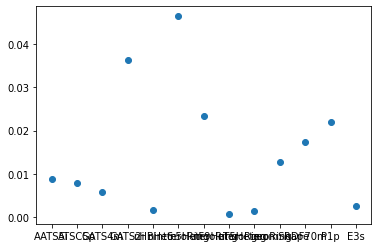

In [23]:
importance['names'] = X.columns
#remove all coefficient that were set to zero by LASSO once in the loop
importance = importance.replace(0, np.nan, regex=True)
importance_nona = importance.dropna()

print('Number of important predictors: ', importance_nona.shape[0])
print('Names of important predictors: ')
print(importance_nona['names'])

mean_importance = pd.DataFrame()
mean_importance['importance'] = importance_nona.mean(axis = 1)
mean_importance = pd.DataFrame(mean_importance)
mean_importance['names'] = importance_nona['names']
mean_importance.head()

#plot 
print('Scatterplot of the most important predictors: ')
plt.scatter(mean_importance['names'], mean_importance['importance'])

In [24]:
#summary 

print('Important predictors: ')
print(mean_importance['names'])
print('Percentage of predictors set to zero: ', (1 - (mean_importance.shape[0]/1875))*100)
print('Number of important predictors: ', mean_importance.shape[0])

#['SM1_Dze', 'SpMax4_Bhs', 'maxHCsats', 'MDEO-22', 'nHeteroRing']

Important predictors: 
116            AATS5i
170            ATSC5p
322            GATS4m
352            GATS2i
671           nHBint6
1336      nHeteroRing
1339     n5HeteroRing
1354    nF9HeteroRing
1361    nT5HeteroRing
1573        geomShape
1616           RDF70m
1839              P1p
1869              E3s
Name: names, dtype: object
Percentage of predictors set to zero:  99.30666666666667
Number of important predictors:  13


Subset only the most important features

Number of predictors:  9
Name of the 25 most important predictors:        importance         names
116     0.008790        AATS5i
170     0.007880        ATSC5p
322     0.005893        GATS4m
352     0.036348        GATS2i
1336    0.046430   nHeteroRing
1339    0.023346  n5HeteroRing
1573    0.012700     geomShape
1616    0.017241        RDF70m
1839    0.021935           P1p


[Text(AATS5i, 0.00879019596863566, 'AATS5i'),
 Text(ATSC5p, 0.007880110995850315, 'ATSC5p'),
 Text(GATS4m, 0.005892571792418758, 'GATS4m'),
 Text(GATS2i, 0.036347608039493835, 'GATS2i'),
 Text(nHeteroRing, 0.046429869629989774, 'nHeteroRing'),
 Text(n5HeteroRing, 0.023345820008694694, 'n5HeteroRing'),
 Text(geomShape, 0.0127001710580991, 'geomShape'),
 Text(RDF70m, 0.017241173953080852, 'RDF70m'),
 Text(P1p, 0.021934771527577356, 'P1p')]

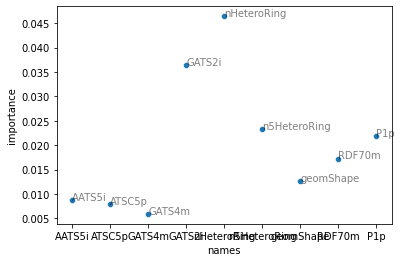

In [25]:
#if the number of important features is lower than 25, then keep them all

importance_25 = pd.DataFrame()
importance_25['importance'] = mean_importance.importance[mean_importance['importance'] >= 0.001]
importance_25['names'] = mean_importance.names[mean_importance['importance'] >= 0.001]
importance_25 = pd.DataFrame(importance_25)

print('Number of predictors: ', importance_25.shape[0])
print('Name of the 25 most important predictors: ', importance_25)

#plot the 25 most important features labelled by their names
sns.scatterplot(data=importance_25,x='names',y='importance')
[plt.text(x=importance_25['names'], y=importance_25['importance'], s=importance_25['names'], fontdict=dict(color='black', alpha=0.5)) 
for k, importance_25 in importance_25.iterrows()]